In [1]:
!wget -q -nc https://raw.githubusercontent.com/pseprivamirakbarnejad/cmput206lab/master/Lab5/im1.jpg
!wget -q -nc https://raw.githubusercontent.com/pseprivamirakbarnejad/cmput206lab/master/Lab5/im2.jpg
!ls

im1.jpg  im2.jpg  sample_data


In [2]:
# Import libraries
from skimage import transform, data, io, exposure, img_as_ubyte, viewer, filters, feature
from skimage import io
from skimage import exposure
import skimage
from skimage.color import rgb2gray
from skimage import transform
import matplotlib.pyplot as plt
import numpy as np
import cv2



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Viewer requires Qt
  """Entry point for launching an IPython kernel.


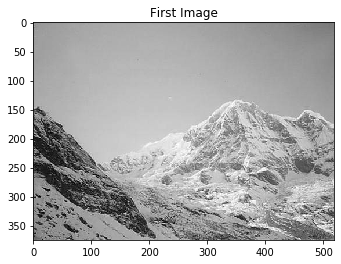

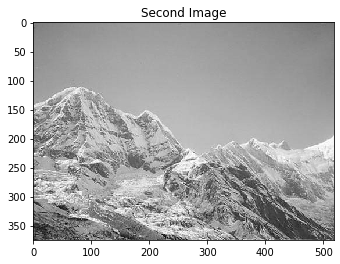

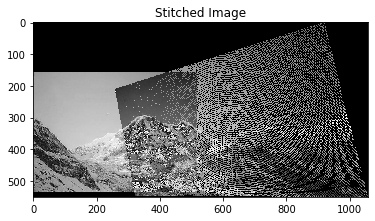

In [5]:
def panorama():

  image0 = img_as_ubyte(io.imread('im1.jpg', True))
  image1 = img_as_ubyte(io.imread('im2.jpg', True))

  plt.title("First Image")
  plt.imshow(image0,cmap='gray')
  plt.show()
  plt.title("Second Image")
  plt.imshow(image1,cmap='gray')
  plt.show()
  #Feature detection and matching

  r1, c1 = image0.shape[:2]
  r2, c2 = image1.shape[:2]
 
  # Initiate ORB detector
  # your code #
  #orb = cv2.ORB_create() --> Not working?
  orb = cv2.BRISK_create()

  # Find the keypoints and descriptors
  # your code #
  keypoints1, descriptors1 = orb.detectAndCompute(image1,None)
  keypoints2, descriptors2 = orb.detectAndCompute(image0,None)

  # initialize Brute-Force matcher and exclude outliers. See match descriptor function.
  # your code #
  bruteForce = cv2.BFMatcher()
  bfMatcher = bruteForce.knnMatch(descriptors1, descriptors2, k=2)

  points = []

  for m,n in bfMatcher:
    if (m.distance < 0.70*n.distance):
      points.append(m)


  # Compute homography matrix 
  # your code #
  if len(points) > 11:
    homogKey1 = np.float32([ keypoints1[m.queryIdx].pt for m in points ]).reshape(-1,1,2)
    homogkey2 = np.float32([ keypoints2[m.trainIdx].pt for m in points ]).reshape(-1,1,2)

    homogMatrix, value= cv2.findHomography(homogKey1, homogkey2, cv2.RANSAC, 2.0)

  #Calculate new coordinates from homogMatrix
  corners = np.zeros((3, r2*c2), dtype=np.int)
  #corners = np.array([[0, 0], [0, r2], [c2, 0],[c2, r2]], dtype=np.int)
  for i in range (r2):
    corners[:, i*c2:(i+1)*c2] = np.matrix([np.arange(c2), [i] * c2,  [1] * c2])
    
  corners_new = homogMatrix * np.matrix(corners)
  corners_new = np.around(np.divide(corners_new, corners_new[2]))

  # Transformation if any negative pixels
  min0 = int(np.amin(corners_new[0]))
  min1 = int(np.amin(corners_new[1]))
  max0 = int(np.amax(corners_new[0]))
  max1 = int(np.amax(corners_new[1]))

  if min0 >= 0:
    new_x = 0
  elif min0<0:
    new_x = -min0
  if min1 >= 0:
    new_y = 0
  elif min1<0:
    new_y = -min1  

  #Setting up new dim
  newR = int(np.maximum(max0, c1) - np.minimum(min0, 0) + 1)
  newH = int(np.maximum(max1, r1) - np.minimum(min1, 0) + 1)

  #Initializing both images
  newImage0 = np.zeros((newH, newR), dtype=np.uint8)
  newImage1 = np.zeros((newH, newR), dtype=np.uint8)

  #First image 
  newImage0[new_y:new_y+r1, new_x:new_x+c1] = image0
    
  for val in range(corners.shape[1]):
    variable0 = (0, val)
    variable1 = (1, val)

    x = corners[variable0]
    y = corners[variable1]

    newX = int(corners_new[variable0])
    newY = int(corners_new[variable1])

    valx = newX + new_x
    valy = newY + new_y

    #Second image 
    newImage1[valy,valx] = image1[y,x]

  #Add the images together 
  finalImg = (newImage0 + newImage1) / 2

  return finalImg 

def main():
  stichedImage = panorama()
  plt.title("Stitched Image")
  plt.imshow(stichedImage, cmap='gray')
  plt.show()

main()

